# Project 2

It is October 2018. The squirrels in Central Park are running into a problem and we need your help.

For this project you must go through most steps in the checklist. You must write responses for all items however sometimes the item will simply be "does not apply". Some of the parts are a bit more nebulous and you simply show that you have done things in general (and the order doesn't really matter). Keep your progress and thoughts organized in this document and use formatting as appropriate (using markdown to add headers and sub-headers for each major part). Do not do the final part (launching the product) and your presentation will be done as information written in this document in a dedicated section, no slides or anything like that. It should however include the best summary plots/graphics/data points.

You are intentionally given very little information thus far. You must communicate with your client (me) for additional information as necessary. But also make sure that your communications are efficient, thought out, and not redundant as your client might get frustrated and "fire" you (this only applies to getting information from your client, this does not necessary apply to asking for help with the actual project itself - you should continuously ask questions for getting help).

You must submit all data files and a pickled preprocessor and final model along with this notebook.

# Frame the Problem and Look at the Big Picture 

1. Define the objective in business terms.
- The objective is to predict which squirrels are 
   sick and which are healthy.<!-- (I think confirm this derek) -->-
- our client is part of the Squirrel census and is interested in the health of the squirrels in Central Park.
- The goal is to predict weather or not a squirrel has a certain disease or not.
2. How will your solution be used?
- The solution will be used to predict the health of the squirrels in Central Park. This could save time and money for the Squirrel census.
3. What are the current solutions/workarounds (if any)?
- The current solution is to send out a team of experts to check the health of the squirrels.
- This is time consuming and expensive, and the team can only check a limited number of squirrels.
4. How should you frame this problem (supervised/unsupervised, online/offline, etc.)?
- This is a supervised learning problem because we have labeled data, and it is to be trained on an online capable system.
5. How should performance be measured?
- The performance should be measured using the F1 score, as we want to have a balance between precision and recall.\
6. What would be the minimum performance needed to reach the business objective?
- The minimum performance needed to reach the business objective is an F1 score of ???
7. What are comparable problems? Can you reuse experience or tools?
- This is a classification problem, and we can use the tools and experience from other classification problems. Data from previous experiences might be used in addition to the tools.
8. Is human expertise available?
- Yes, human expertise is availabe. Our client is part of the Squirrel census and has a lot of knowledge about the health of the squirrels in Central Park.
9. How would you solve the problem manually?
- The problem could be solved manually by sending out a team of experts to check the health of the squirrels.
10. List the assumptions you (or others) have made so far.
- The data is accurate and up to date.
- The data is labeled correctly.

----
----


# Get the Data

1. List the data you need and how much you need.
   - We will need the diseased squirrel data which was provided by the client and the 2018 squirrel census data, along with weather data that is realevent to the target area. 
2. Find and document where you can get that data.
    - The data was obtained from the [NYC OpenData Collections](https://data.cityofnewyork.us/Environment/2018-Central-Park-Squirrel-Census-Squirrel-Data/vfnx-vebw/about_data), [Weather Data](https://www.ncei.noaa.gov/data/daily-summaries/doc/GHCND_documentation.pdf)  and obtained from the client.
    
3. Get access authorizations.
    - N/A
4. Create a workspace (with enough storage space).
    - N/A
5. Get the data.
    - N/A
6. Convert the data to a format you can easily manipulate (without changing the data itself).
    - The data is in three separate CSV files. We will load the data into a pandas DataFrame, and combine the data into a single DataFrame. (to be easily manipulated)
7. Ensure sensitive information is deleted or protected (e.g. anonymized).
    - N/A
8. Check the size and type of data (time series, sample, geographical, etc.).
    - The data is sample data and includes location data for each of the squirrels. 
9. Sample a test set, put it aside, and never look at it (no data snooping!).
    - We will sample 10% of the data and put it aside.

----
----

# Imports
----
----

In [48]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler
from pandas.tseries.offsets import MonthEnd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report , confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import set_config
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx


set_config(transform_output = "pandas")

ModuleNotFoundError: No module named 'geopandas'

----
----
# Data Load
----
----

In [23]:
census = pd.read_csv('2018_Central_Park_Squirrel_Census_-_Squirrel_Data_20241105.csv')
weather = pd.read_csv('weather.csv')
disease = pd.read_csv('diseased_squirrels.csv',header=None)


In [24]:
diseased_ids = disease[0].tolist()

# Create a 'Diseased' column in the census data
census['Diseased'] = census['Unique Squirrel ID'].isin(diseased_ids)

----
----
# Data Exploration and Visualization 

### Objectives 
The client has requested help to identify squirrels that are diseased and they will use this information to help their team more efficiently treat the affected population. 

The client has noted that they have limited man power, so we will prioritize making sure the predictions made by the model will have high precision and have the least ammount of false positives as possible. 

Exploring the data will be done to attempt to find any useful correlations that would be useful for the machine learning process. 



## Plots
----
----

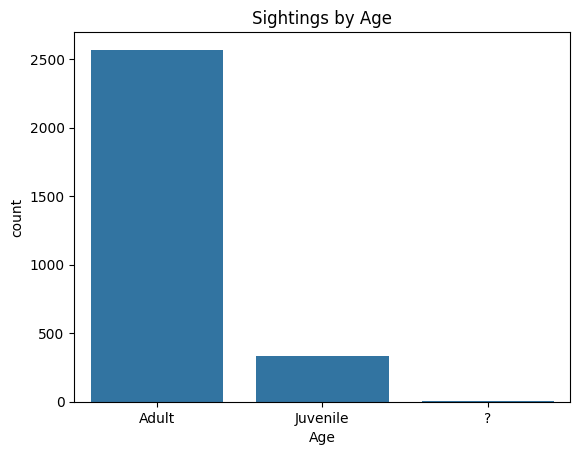

Age
Adult       0.884907
Juvenile    0.113715
?           0.001378
Name: count, dtype: float64

In [22]:
# plot of sightings by age 
sns.countplot(x='Age', data=census)
plt.title('Sightings by Age')
plt.show()

# percentage of squirrel by age

age_counts = census['Age'].value_counts()
age_counts = age_counts / age_counts.sum()
age_counts



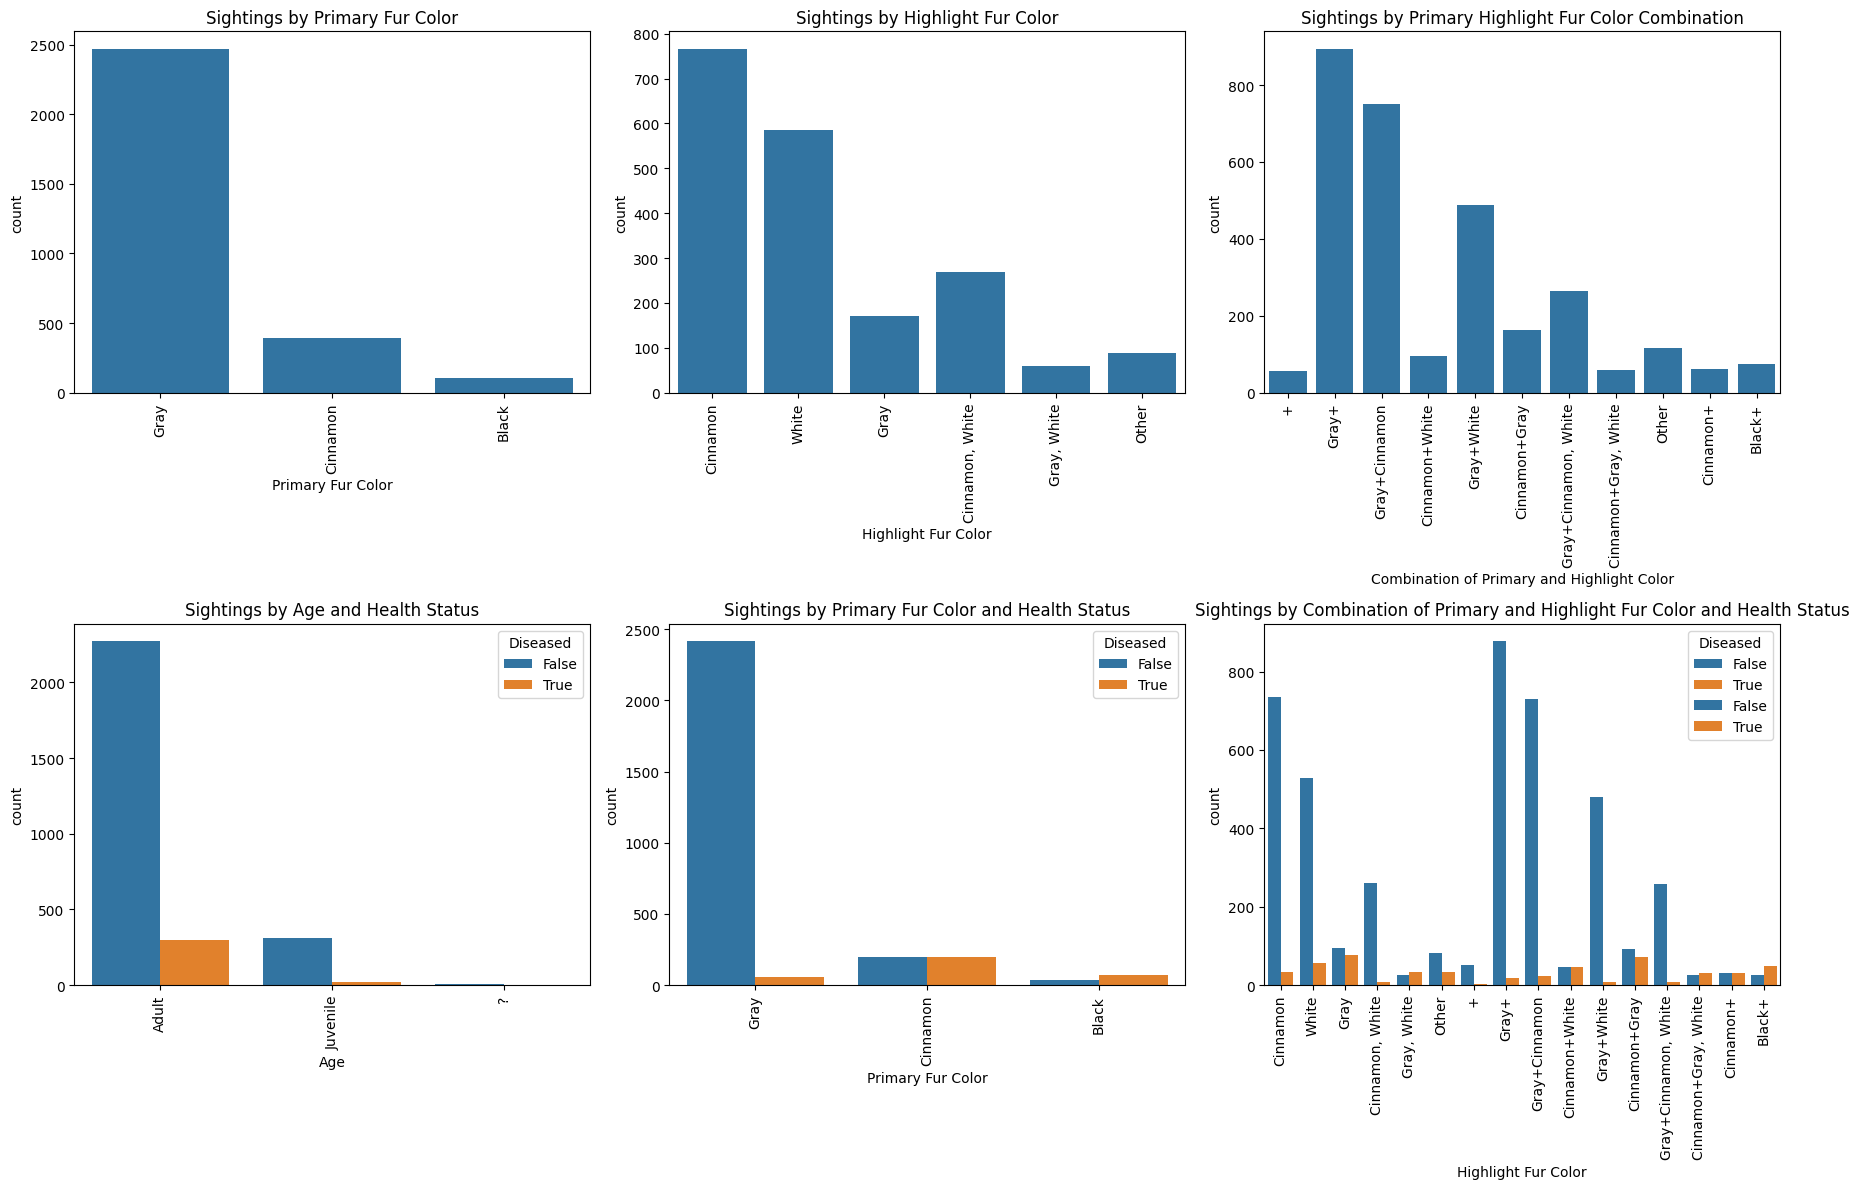

In [29]:
# Group less frequent categories into 'Other' for Primary Fur Color
primary_fur_color_counts = census['Primary Fur Color'].value_counts()
primary_fur_color_threshold = 50  
primary_fur_color_other = primary_fur_color_counts[primary_fur_color_counts < primary_fur_color_threshold].index
census['Primary Fur Color'] = census['Primary Fur Color'].replace(primary_fur_color_other, 'Other')

# Group less frequent categories into 'Other' for Highlight Fur Color
highlight_fur_color_counts = census['Highlight Fur Color'].value_counts()
highlight_fur_color_threshold = 50  
highlight_fur_color_other = highlight_fur_color_counts[highlight_fur_color_counts < highlight_fur_color_threshold].index
census['Highlight Fur Color'] = census['Highlight Fur Color'].replace(highlight_fur_color_other, 'Other')

# Group less frequent categories into 'Other' for Combination of Primary and Highlight Color
combination_color_counts = census['Combination of Primary and Highlight Color'].value_counts()
combination_color_threshold = 50  
combination_color_other = combination_color_counts[combination_color_counts < combination_color_threshold].index
census['Combination of Primary and Highlight Color'] = census['Combination of Primary and Highlight Color'].replace(combination_color_other, 'Other')

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Bar plot of percentage of squirrels by primary fur color
sns.countplot(x='Primary Fur Color', data=census, ax=axes[0, 0])
axes[0, 0].set_title('Sightings by Primary Fur Color')
axes[0, 0].tick_params(axis='x', rotation=90)

# Bar plot of percentage of squirrels by highlight fur color
sns.countplot(x='Highlight Fur Color', data=census, ax=axes[0, 1])
axes[0, 1].set_title('Sightings by Highlight Fur Color')
axes[0, 1].tick_params(axis='x', rotation=90)

# Bar plot of percentage of squirrels by combination of primary and highlight fur color
sns.countplot(x='Combination of Primary and Highlight Color', data=census, ax=axes[0, 2])
axes[0, 2].set_title('Sightings by Primary Highlight Fur Color Combination')
axes[0, 2].tick_params(axis='x', rotation=90)

# plot of count of squirrels that are healthy and diseased by age
sns.countplot(x='Age', hue='Diseased', data=census, ax=axes[1, 0])
axes[1, 0].set_title('Sightings by Age and Health Status')
axes[1, 0].tick_params(axis='x', rotation=90)

# plot of count of squirrels that are healthy and diseased by primary fur color
sns.countplot(x='Primary Fur Color', hue='Diseased', data=census, ax=axes[1, 1])
axes[1, 1].set_title('Sightings by Primary Fur Color and Health Status')
axes[1, 1].tick_params(axis='x', rotation=90)

# plot of count of squirrels that are healthy and diseased by highlight fur color
sns.countplot(x='Highlight Fur Color', hue='Diseased', data=census, ax=axes[1, 2])
axes[1, 2].set_title('Sightings by Highlight Fur Color and Health Status')
axes[1, 2].tick_params(axis='x', rotation=90)

# plot of count of squirrels that are healthy and diseased by combination of primary and highlight fur color
sns.countplot(x='Combination of Primary and Highlight Color', hue='Diseased', data=census, ax=axes[1, 2])
axes[1, 2].set_title('Sightings by Combination of Primary and Highlight Fur Color and Health Status')
axes[1, 2].tick_params(axis='x', rotation=90)


plt.tight_layout()
plt.show()


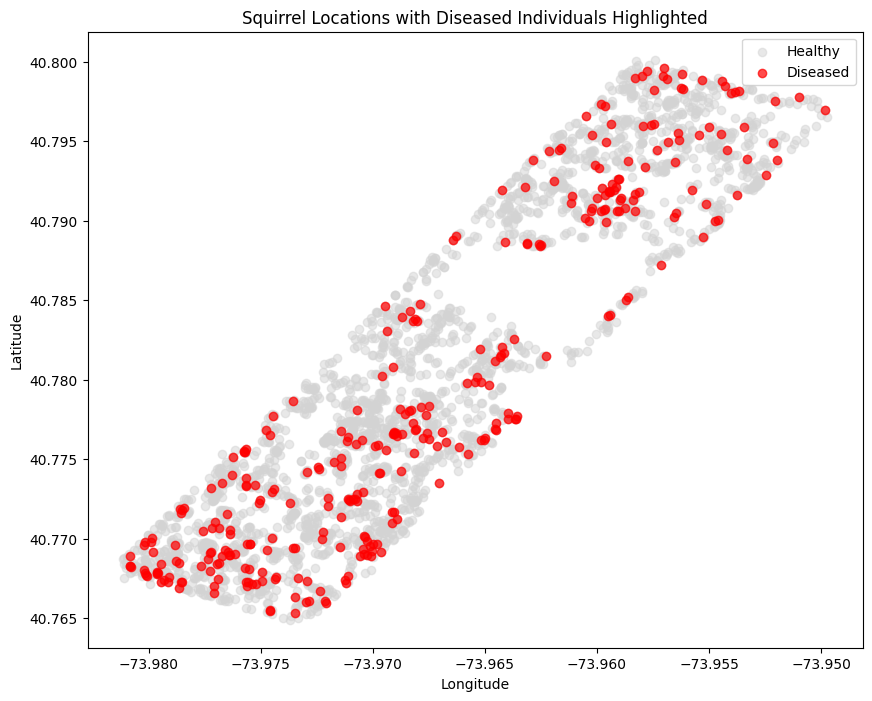

In [30]:
# Plot all squirrels
plt.figure(figsize=(10, 8))
plt.scatter(census['X'], census['Y'], c='lightgrey', label='Healthy', alpha=0.5)

# Highlight diseased squirrels
diseased_squirrels = census[census['Diseased']]
plt.scatter(diseased_squirrels['X'], diseased_squirrels['Y'], c='red', label='Diseased', alpha=0.7)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Squirrel Locations with Diseased Individuals Highlighted')
plt.legend()
plt.show()

/var/folders/f8/pyz20pzd513676ck8xv53jsm0000gp/T/ipykernel_55481/3437729056.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=diseased_squirrels['X'], y=diseased_squirrels['Y'], cmap="Reds", shade=True, bw_adjust=.5)


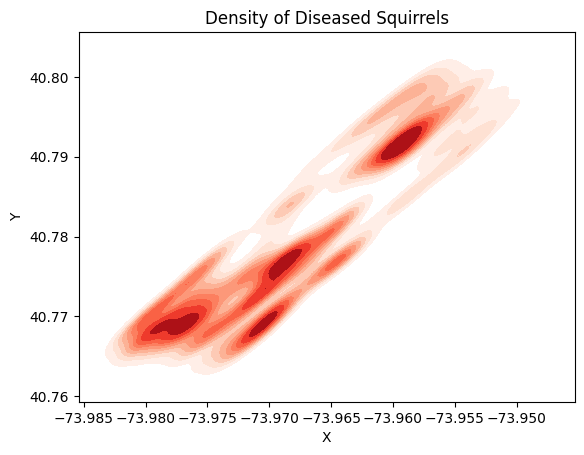

In [31]:
# Density Estimation plot for diseased squirrels
sns.kdeplot(x=diseased_squirrels['X'], y=diseased_squirrels['Y'], cmap="Reds", shade=True, bw_adjust=.5)
plt.title('Density of Diseased Squirrels')
plt.show()


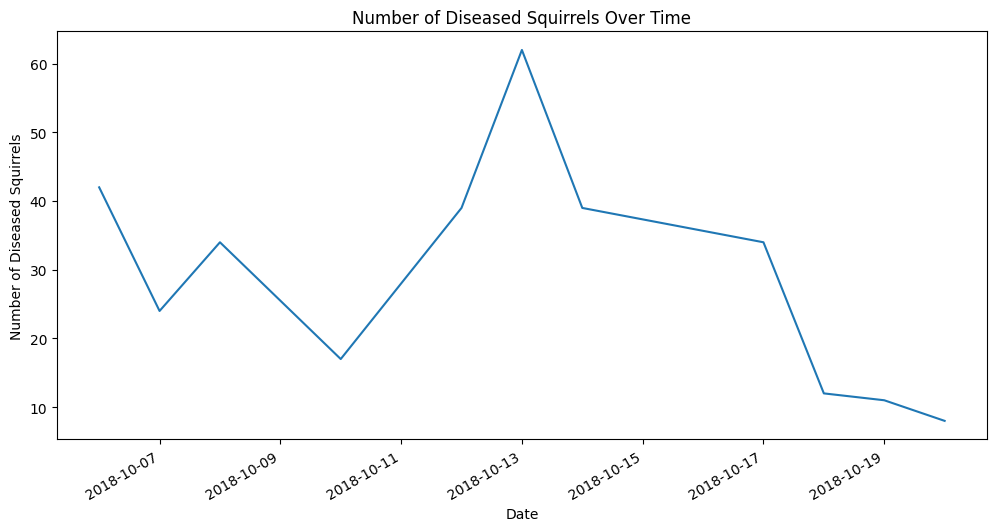

In [32]:
census['Date'] = pd.to_datetime(census['Date'], format='%m%d%Y')

# Time series plot
census.set_index('Date', inplace=True)
disease_time_series = census.groupby('Date')['Diseased'].sum()

plt.figure(figsize=(12, 6))
disease_time_series.plot()
plt.title('Number of Diseased Squirrels Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Diseased Squirrels')
plt.show()


---
### Join weather data 


In [33]:
# Reset index to access 'Date' column
census.reset_index(inplace=True)

# Convert date column in census and weather data to datetime
census['Date'] = pd.to_datetime(census['Date'], format='%m%d%Y')
weather['DATE'] = pd.to_datetime(weather['DATE'], format='%Y-%m-%d')

# Merge the census and weather data on the date column
census_weather = pd.merge(census, weather, left_on='Date', right_on='DATE', how='inner')

# Align date range to census data
census_weather = census_weather[(census_weather['Date'] >= '2018-10-01') & (census_weather['Date'] <= '2018-10-31')]

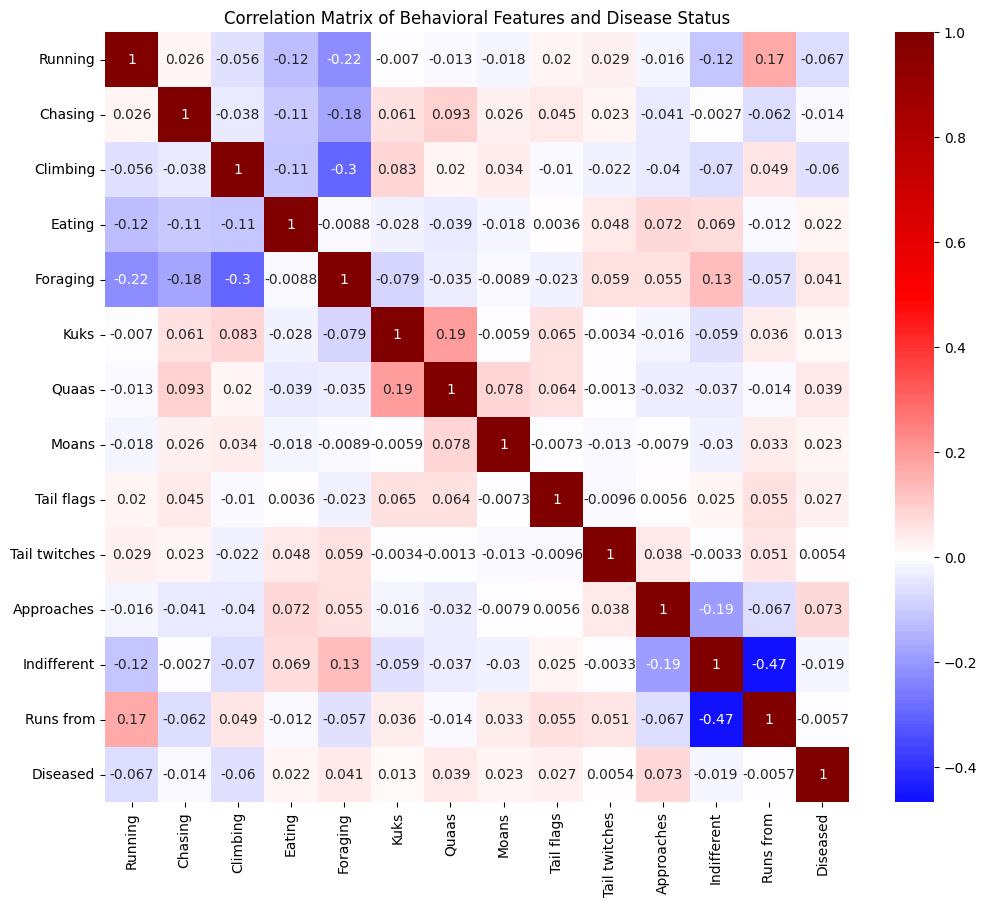

In [34]:
#select only the numeric columns
census_weather_numeric = census_weather.select_dtypes(include=[np.number])

behavioral_features = ['Running', 'Chasing', 'Climbing', 'Eating', 'Foraging','Kuks','Quaas','Moans','Tail flags','Tail twitches','Approaches','Indifferent','Runs from']

behavioral_features_diseased = census_weather[behavioral_features + ['Diseased']]
behavioral_features_diseased = behavioral_features_diseased.dropna()

correlation_matrix = behavioral_features_diseased.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='seismic', center=0)
plt.title('Correlation Matrix of Behavioral Features and Disease Status')
plt.show()

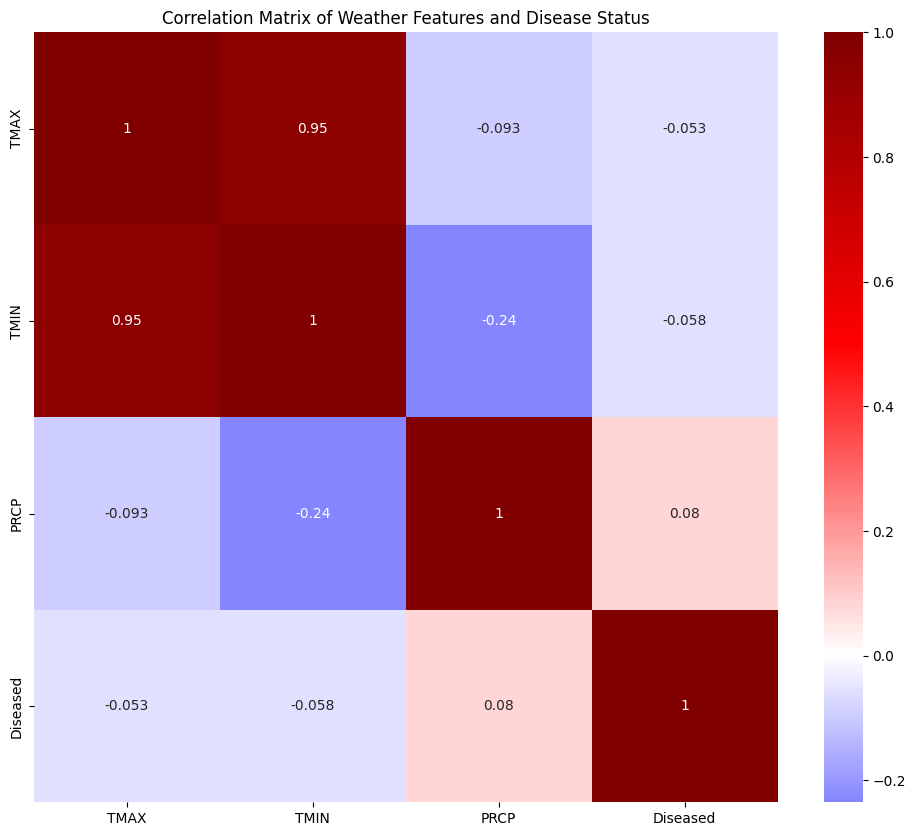

In [40]:
#create a corelation matrix for the weather data and the disease status
weather_features = ['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD', 'Diseased']
weather_features_diseased = census_weather[weather_features]
weather_features_diseased = weather_features_diseased.dropna()
#drop snow and snwd as they have a correlation of 1
weather_features_diseased = weather_features_diseased.drop(columns=['SNOW', 'SNWD'])


correlation_matrix = weather_features_diseased.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='seismic', center=0)
plt.title('Correlation Matrix of Weather Features and Disease Status')
plt.show()


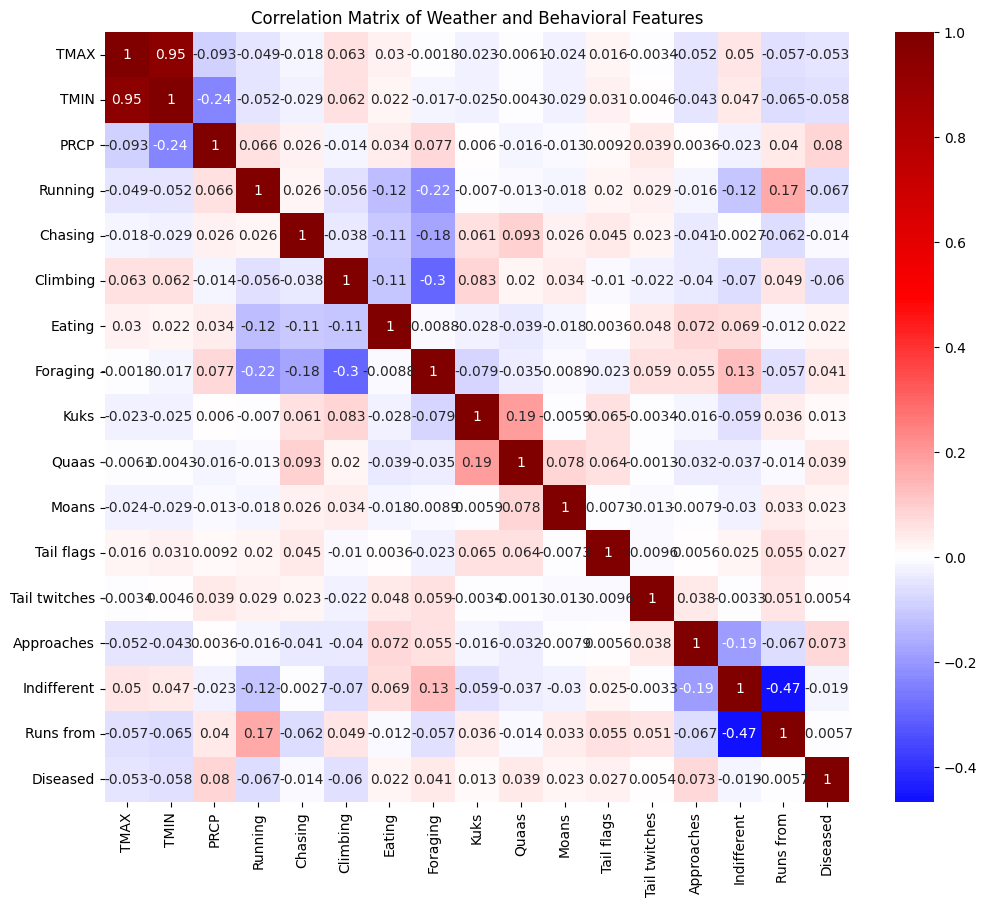

In [39]:
# create a corelation matrix for weather and behavioral features and the disease status
weather_behavioral_features = ['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD', 'Running', 'Chasing', 'Climbing', 'Eating', 'Foraging','Kuks','Quaas','Moans','Tail flags','Tail twitches','Approaches','Indifferent','Runs from','Diseased']
weather_behavioral_features_diseased = census_weather[weather_behavioral_features]
weather_behavioral_features_diseased = weather_behavioral_features_diseased.dropna()

weather_behavioral_features_diseased = weather_behavioral_features_diseased.drop(['SNOW','SNWD'], axis=1)

correlation_matrix = weather_behavioral_features_diseased.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='seismic', center=0)
plt.title('Correlation Matrix of Weather and Behavioral Features')
plt.show()



Using the combination of weather and beahavior we are able to see that there are correlations related to squirrel acitivty, and weather but there is little correlation between diseased and weather features. 


### Below is a selection of features that will be used by our model and our assumptions on their usecase along with the amount of missing data per feature 
----

| Name | Type | Noise | Useful |  |
|---|---|---|---|---|
| Date | datetime |  | yes (axis) |  |
| X | float |  | yes(location) |  |
| Y | float |  | yes(location) |  |
| Unique Squirrel ID' | object |  | useful for seeing if  healthy or sick  |  |
| Hectare | object |  | possible  |  |
| Hectare Squirrel Number | int  |  | possible  |  |
| Age | object  | missing 4% values and ? values are unknown | yes |  |
| Primary Fur Color | object | missing 2% values  | yes |  |
| Highlight Fur Color | object | missing 36% values  | yes |  |
| Combination of Primary and Highlight Color | object |  | yes |  |
| Color notes | object | missing 94% values  | yes |  |
| Location | object | missing 2% values  | yes |  |
| Above Ground Sighter Measurement | object   | missing 4% values | possible  |  |
| Specific Location | object (int)  | missing 84% values  | possible  |  |
| Running | bool  |  | yes |  |
| Chasing | bool |  | yes |  |
| Climbing | bool |  | yes |  |
| Eating | bool |  | yes |  |
| Foraging | bool |  | yes |  |
| Other Activities | object (string) | missing 86% values  | yes |  |
| Kuks | bool |  | yes |  |
| Quaas | bool |  | yes |  |
| Tail flags | bool |  | yes |  |
| Tail twitches | bool |  | yes |  |
| Approaches | bool |  | yes |  |
| Indifferent | bool |  | yes |  |
| Runs from | bool |  | yes |  |
| Other Interactions | object (string) | 92% missing values | possible  |  |
| Lat/Long | object |  | yes (is the same as x & Y) |  |
| DATE | datetime |  |  |  |
| AWND | int  | 48% missing values  | yes |  |
| PRCP | int  |  | yes |  |
| TMAX | int  |  | yes |  |
| TMIN | int |  | yes |  |
| WDF2 | int | 48% missing values | yes |  |
| WDF5 | int | 48% missing values  | yes |  |
| WSF2 | int | 48% missing values | yes |  |
| WSF5 | int | 48% missing values | yes |  |

Going through the data we have found that the Features with missing values are:
* Age
 121
* Primary Fur Color
55
* Highlight Fur Color
1,086
* Color notes
2,841
* Location
64
* Above Ground Sighter Measurement
114
* Specific Location
2,547
* Other Activities
2,586
* Other Interactions
2,783
* AWND
1,443
* WDF2
1,443
* WDF5
1,443
* WSF2
1,443
* WSF5
1,443

| Vector             | OneHot                                     | Numerical                                                     | Other                   |   |
|--------------------|--------------------------------------------|---------------------------------------------------------------|-------------------------|---|
| Color notes        | Age                                        | Above Ground Sighter Measurement  (need to change false to 0) | Unique Squirrel ID      |   |
| Specific Location  | Primary Fur Color                          | AWND                                                          | Hectare                 |   |
| Other Activities   | Highlight Fur Color                        | PRCP                                                          | Date                    |   |
| Other Interactions | Combination of Primary and Highlight Color | TMAX                                                          | Hectare Squirrel Number |   |
|                    | Location                                   | TMIN                                                          | Lat/Long                |   |
|                    | Running                                    | WDF2                                                          |                         |   |
|                    | Chasing                                    | WDF5                                                          |                         |   |
|                    | Climbing                                   | WSF2                                                          |                         |   |
|                    | Eating                                     | WSF5                                                          |                         |   |
|                    | Foraging                                   | Hectare Squirrel Number                                       |                         |   |
|                    | Kuks                                       |                                                               |                         |   |
|                    | Quaas                                      |                                                               |                         |   |
|                    | Moans                                      |                                                               |                         |   |
|                    | Tail flags                                 |                                                               |                         |   |
|                    | Tail twitches                              |                                                               |                         |   |
|                    | Approaches                                 |                                                               |                         |   |
|                    | Indifferent                                |                                                               |                         |   |
|                    | Runs from                                  |                                                               |                         |   |
|                    | Diseased                                   |                                                               |                         |   |
|                    |                                            |                                                               |                         |   |

-----
# Pipeline 

In [ ]:
#drop columns that have 100% missing values
census_weather = census_weather.dropna(axis=1, how='all')


# list of features to drop
features_to_drop = [ 'Shift', 'STATION','NAME','LATITUDE','LONGITUDE',
                    'ELEVATION','PRCP_ATTRIBUTES','SNOW','SNOW_ATTRIBUTES','SNWD'
                    ,'SNWD_ATTRIBUTES','TMAX_ATTRIBUTES','TMIN_ATTRIBUTES','WT01','WT01_ATTRIBUTES',
                    'AWND_ATTRIBUTES','PRCP_ATTRIBUTES','WDF2_ATTRIBUTES', 'WDF5_ATTRIBUTES',
                    'WSF2_ATTRIBUTES', 'WSF5_ATTRIBUTES','WT08', 'WT08_ATTRIBUTES']


# function to drop the features
def drop_features(data, features_to_drop):
    data = data.drop(features_to_drop, axis=1)
    return data



In [53]:
census_weather = drop_features(census_weather, features_to_drop)

#split the data into features and target
X = census_weather.drop(columns=['Diseased'])
y = census_weather['Diseased']


# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class DateMergerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Convert 'Date' and 'DATE' to datetime, handling errors
        X['Date'] = pd.to_datetime(X['Date'], errors='coerce')
        X['DATE'] = pd.to_datetime(X['DATE'], errors='coerce')

        # Combine the dates, prioritizing non-null values
        X['MergedDate'] = X[['Date', 'DATE']].max(axis=1)

        # Extract date features
        date_features = pd.DataFrame({
            'year': X['MergedDate'].dt.year,
            'month': X['MergedDate'].dt.month,
            'day': X['MergedDate'].dt.day,
            'weekday': X['MergedDate'].dt.weekday
        })

        # Handle missing values by filling with zeros
        date_features = date_features.fillna(0)

        # Reset index to align with other data
        return date_features.reset_index(drop=True)


class BoolTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        boolean_columns = [
            'Running', 'Chasing', 'Climbing', 'Eating', 'Foraging', 'Kuks',
            'Quaas', 'Moans', 'Tail flags', 'Tail twitches', 'Approaches',
            'Indifferent', 'Runs from'
        ]
        X[boolean_columns] = X[boolean_columns].astype(int)
        return X

class PreprocessBooleansAboveGroundTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass  # No hyperparameters to initialize

    def fit(self, X, y=None):
        return self  # No fitting necessary

    def transform(self, X):
        X = X.copy()
        # Replace 'FALSE' with 0 in 'Above Ground Sighter Measurement'
        X['Above Ground Sighter Measurement'] = X['Above Ground Sighter Measurement'].replace('FALSE', 0)

        # Convert 'Above Ground Sighter Measurement' to numeric
        X['Above Ground Sighter Measurement'] = pd.to_numeric(X['Above Ground Sighter Measurement'], errors='coerce')

        # Convert boolean columns to integers (0 for False, 1 for True)
        boolean_columns = [
            'Running', 'Chasing', 'Climbing', 'Eating', 'Foraging', 'Kuks',
            'Quaas', 'Moans', 'Tail flags', 'Tail twitches', 'Approaches',
            'Indifferent', 'Runs from'
        ]
        X[boolean_columns] = X[boolean_columns].astype(int)

        return X

def combine_text_columns(X):
    combined_series = X.fillna('missing').agg(' '.join, axis=1)
    # Return a DataFrame with the combined text
    return pd.DataFrame({'combined_text': combined_series})


# Define column groups
boolean_columns = [
    'Running', 'Chasing', 'Climbing', 'Eating', 'Foraging', 'Kuks', 'Quaas',
    'Moans', 'Tail flags', 'Tail twitches', 'Approaches', 'Indifferent', 'Runs from'
]

numerical_columns = [
    'AWND', 'PRCP', 'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5',
    'Hectare Squirrel Number', 'Above Ground Sighter Measurement', 'X', 'Y'
]

one_hot_columns = [
    'Primary Fur Color', 'Location', 'Highlight Fur Color', 'Age',
    'Hectare', 'Combination of Primary and Highlight Color'
]

text_columns = [
    'Other Activities', 'Other Interactions', 'Specific Location', 'Color notes'
]

# Convert text columns to string type
X_train[text_columns] = X_train[text_columns].astype(str)
X_test[text_columns] = X_test[text_columns].astype(str)


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

text_transformer = Pipeline(steps=[
    ('combine_text', FunctionTransformer(combine_text_columns, validate=False)),
    ('extract_text', FunctionTransformer(lambda X: X['combined_text'], validate=False)),
    ('tfidf', TfidfVectorizer(max_features=5000))
])

boolean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('bool_to_int', BoolTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, one_hot_columns),
        ('bool', boolean_transformer, boolean_columns),
        ('text', text_transformer, text_columns),
        ('date', DateMergerTransformer(), ['Date', 'DATE'])
    ],
    remainder='drop'  # Exclude unhandled columns
)

# Build the pipeline with the new transformer
pipeline = Pipeline(steps=[
    ('preprocess_booleans', PreprocessBooleansAboveGroundTransformer()),
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])


# Fit the pipeline
pipeline.fit(X_train, y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:303: UserWarning: When `set_output` is configured to be 'pandas', `func` should return a pandas DataFrame to follow the `set_output` API  or `feature_names_out` should be defined.
  warnings.warn(warn_msg.format("pandas"))


Pipeline(steps=[('preprocess_booleans',
                 PreprocessBooleansAboveGroundTransformer()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['AWND', 'PRCP', 'TMAX',
                                                   'TMIN', 'WDF2', 'WDF5',
                                                   'WSF2', 'WSF5',
                                                   'Hectare Squirrel Number',
                                                   'Above Ground Sighter '
                                                   'Measurement',
                                                   'X', 'Y']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleI...
                                                                   FunctionTransformer(func=<function combine_text_columns at 0x16e71e200>)),
                                                                  ('extract_text',
                                                                   FunctionTransformer(func=<function <lambda> at 0x16a642200>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer(max_features=5000))]),
                                                  ['Other Activities',
                                                   'Other Interactions',
                                                   'Specific Location',
                                                   'Color notes']),
                                                 ('date',
                                                  DateMergerTransformer(),
                                                  ['Date', 'DATE'])])),
                ('classifier', RandomForestClassifier())])

----
## Model Selection and Tunning 

In [58]:
#run the pipeline on the test data with a logistic regression classifier
from sklearn.metrics import recall_score


pipeline = Pipeline(steps=[
    ('preprocess_booleans', PreprocessBooleansAboveGroundTransformer()),
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

pipeline.fit(X_train, y_train)

# Predict on the test data

y_pred = pipeline.predict(X_test)



#get recall 
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")
# get cross validation score
cv_score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='precision')
print(f"Cross-validation Recall: {cv_score.mean()}")



/opt/homebrew/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:303: UserWarning: When `set_output` is configured to be 'pandas', `func` should return a pandas DataFrame to follow the `set_output` API  or `feature_names_out` should be defined.
  warnings.warn(warn_msg.format("pandas"))
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:303: UserWarning: When `set_output` is configured to be 'pandas', `func` should ret

Recall: 0.15789473684210525


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:303: UserWarning: When `set_output` is configured to be 'pandas', `func` should return a pandas DataFrame to follow the `set_output` API  or `feature_names_out` should be defined.
  warnings.warn(warn_msg.format("pandas"))
/opt/homebrew/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:303: UserWarning: When `set_output` is configured to be 'pandas', `func` should ret

Cross-validation Recall: 0.543516342429386


In [59]:
# Grid search on logistic regression
param_grid = {
    'classifier__C': [0.01, 0.001, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='precision',
                            n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits


KeyboardInterrupt: 